In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit

#Add util to the path
import sys
sys.path.append('../util')

from fitting_functions_ZNE import third_no_first_ZNE, converge_ZNE_loocv


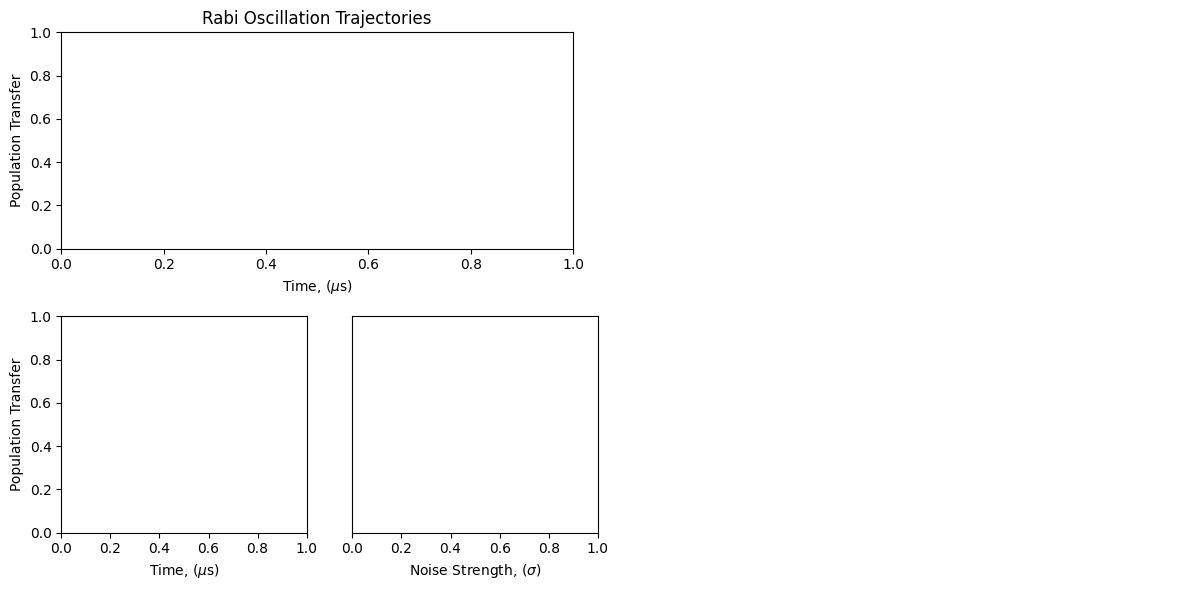

In [2]:
"""Figure includes Rabi oscillations for Gaussian noise, and regions for Rydberg and trapped ion error mechanisms. 
|---|--|
|   |  |
|-|-|--|
| | |  |
|-|-|--|
"""
#Create a matplotlib subplots in the layout above
fig = plt.figure(figsize=(12, 6))
ax_a = fig.add_subplot(221)
ax_bi = fig.add_subplot(245)
ax_bii = fig.add_subplot(246)
ax_c = fig.add_subplot(222)
ax_d = fig.add_subplot(224)
#don't display the ax_c and ax_d plots
ax_c.axis('off')
ax_d.axis('off')
#Make the ticks on ax_bii on the  right instead of left:
ax_bii.yaxis.tick_right()
#turn off the 

#Axis a
ax_a.set_xlabel(r'Time, ($\mu$s)')
ax_a.set_title('Rabi Oscillation Trajectories')
ax_a.set_ylabel('Population Transfer')
#Axis b (i)
ax_bi.set_xlabel(r'Time, ($\mu$s)')
ax_bii.set_xlabel(r'Noise Strength, ($\sigma$)')
ax_bi.set_ylabel('Population Transfer')
ax_bii.set_yticks([])

#ax_bii.set_ylabel('Population Transfer')
#Set the ax_bii y-axis equal to the ax_bi y-axis
#ax_bii.set_ylim(ax_bi.get_ylim())


fig.tight_layout()
#plt.show()


In [3]:
#Reading in Or Data:
#Data files:
#Output data: 
#shape = heating, time, qubit
def exp_fit(t, A, B, C, D):
    return A*np.exp(-B*t)*np.cos(C*t+D) + A
def rabi_fit(t, Omega):
    return (1-np.cos(Omega*t))/2
KHz = 1e3
micro = 1e-6
Omega =  2210*KHz
sigma = .07*Omega
delta_samples = 1000
nano = 1e-9
n_bar = 800


t = np.linspace(0, 40*micro, delta_samples)
def Rabi(Omega_array, t_array):
    output = np.zeros((len(Omega_array), len(t_array)))
    for i, Omega in enumerate(Omega_array):
        output[i] = (1-np.cos(Omega*t_array/2))/2
    return output



def sample_thermal_n(n_bar:int, n_max:int):
    
    def pr_n(n: int, n_bar:int):
        """Returns the probability of sampling the value $n$ from the thermal distribution"""
        return (1/(1 + n_bar)) * np.power((n_bar/(1 + n_bar)),n)
        return (1 - n_bar) * n_bar**n
    pr_0 = pr_n(0, n_bar)
    
    n = np.random.randint(0, n_max)
    r = np.random.uniform(0, pr_0)
    pr_n_sample = pr_n(n, n_bar)
    while r > pr_n_sample:
        n = np.random.randint(0, n_max)
        r = np.random.uniform(0, pr_0)
        pr_n_sample = pr_n(n, n_bar)
    return n

def sample_normal(theta:float):
    
    return np.random.normal(0, theta)
    #return n
    
#Plotting the first Omega:
Omega_test = 1648442
theta_alpha = -42409
Omega_test = 3750000
times = np.linspace(0, 10*micro, 1000)
#times = times*micro
n_bar = 0.05
delta_thermal = np.array([sample_normal(n_bar) for i in range(100)])
P_thermal = Rabi(Omega_test*(1+delta_thermal), times)
P_avg_thermal = np.mean(P_thermal, axis=0)

times_dense = np.linspace(0, 10*micro, 1000)
times_dense_plotting = np.linspace(0, 10, 1000)
P_thermal_dense = Rabi(Omega_test*(1+delta_thermal), times_dense)
#print(P_thermal_dense.shape)
P_avg_thermal_dense = np.mean(P_thermal_dense, axis=0)
#print(P_avg_thermal_dense)

def gen_noisy_rabi(Omega, theta, delta_samples):
    delta_thermal = np.array([sample_normal(theta) for i in range(delta_samples)])
    P_thermal = Rabi(Omega*(1+delta_thermal), times_dense)
    #print(P_thermal.shape)
    P_avg_thermal = np.mean(P_thermal, axis=0)
    P_std_thermal = np.std(P_thermal, axis=0)/np.sqrt(delta_samples)
    return P_avg_thermal, P_std_thermal

In [4]:

for i in range(0,P_thermal_dense.shape[0]):

    ax_a.plot(times_dense_plotting, P_thermal_dense[i,:], 'b', alpha=0.02, zorder=-1) 
ax_a.plot(times_dense_plotting, P_avg_thermal_dense, 'b', alpha=0.5, zorder=-1, label='Noisy Trajectories')
ax_a.plot(times_dense_plotting, P_avg_thermal_dense, c='k', label='Averaged Expectation')
ax_a.legend(loc='lower right')
ZNE_points = np.array([0, 1, 1.1, 1.3, 1.6, 2, 2.5])
baseline = 0.05
shots = 1000
#get a blue to red colormap
cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, len(ZNE_points)))
#print(colors)
#Add a color bar:
colorbar = plt.cm.ScalarMappable(cmap=cmap)
colorbar.set_array(ZNE_points*baseline)

#Add color bar to ax_bii
cbar = plt.colorbar(colorbar, ax=ax_bii)
cbar.set_label(r'Error Strength, $\sigma$')

ZNE_data = np.zeros((len(times_dense), len(ZNE_points)))
ZNE_std = np.zeros((len(times_dense), len(ZNE_points)))
for i in range(len(ZNE_points)):
    color = colors[i]
    ZNE_data[:,i], ZNE_std[:,i] = gen_noisy_rabi(Omega_test, baseline*ZNE_points[i], shots)
    ax_bi.plot(times_dense_plotting, ZNE_data[:,i], c=color, alpha=1)
    
#Draw a vertial line at the 3rd peak:
peak_index = 840
ax_bi.axvline(x=times_dense_plotting[peak_index], c='k', linestyle='--')

#Plot the extrapolation:
print(colors[0,])
for i in range(len(ZNE_points)):
    color = colors[i,:]
    print(color)
    if i == 0:
        color = 'k'
    ax_bii.errorbar(ZNE_points[i]*baseline, ZNE_data[peak_index,i], yerr=ZNE_std[peak_index,i], color=color, fmt='o')
    #ax_bii.errorbar(ZNE_points*baseline, ZNE_data[peak_index,:], yerr=ZNE_std[peak_index,:], color=colors[:,0], fmt='o')  
#Fit to third_no_first
function = converge_ZNE_loocv(ZNE_points*baseline, ZNE_data[peak_index,:])
ZNE_points_dense = np.linspace(0, 2.5, 1000)*baseline
ax_bii.plot(ZNE_points_dense, function(ZNE_points_dense), c='k', label='Polynomial Fit', ls='--')
#ax_bii.text(0.1, 0.3, 'Add Error bars\n Add error vs. time?\n Fix spacings', transform=ax_bii.transAxes)
ax_bii.legend(loc='upper right')
#Get the ZNE points
ZNEd_data = np.zeros((len(times_dense)))
for i in range(len(times_dense)):
    data = ZNE_data[i,:]
    function = third_no_first_ZNE(ZNE_points*baseline, data)
    ZNEd_data[i] = function(0)

ax_bi.plot(times_dense_plotting, ZNEd_data, c='k', linestyle='--', label='ZNE Points')


[0.2298057  0.29871797 0.75368315 1.        ]
[0.2298057  0.29871797 0.75368315 1.        ]
[0.43581481 0.5707073  0.95171738 1.        ]
[0.66725292 0.77917646 0.99295921 1.        ]
[0.86742764 0.8643766  0.86260246 1.        ]
[0.9682034  0.7208441  0.61229299 1.        ]
[0.90578348 0.45518569 0.35533588 1.        ]
[0.70567316 0.01555616 0.15023281 1.        ]


/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 640x480 with 0 Axes>

In [5]:
plt.show()
print(fig)
fig.savefig('Figure_1.png', dpi=600)
fig.savefig('Figure_1.svg', dpi=600)


Figure(1200x600)
